In [1]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

from astropy.table import Table,join,hstack,vstack
import glob
import numpy as np
import matplotlib.pyplot as plt
import corner

In [2]:
# First read in the unvalidated GALAH DR4 file
galah_dr4_raw = Table.read('../analysis_products/galah_dr4_allspec_not_validated.fits')
galah_dr4_raw['source_id'] = galah_dr4_raw['gaia_edr3_source_id']

In [3]:
# Then read in GALAH DR3
seismic = Table.read('../auxiliary_information/Zinn_Table2_eDR3_xmatch.fits')

In [4]:
# Join them with the tmass_id keyword
joined = join(galah_dr4_raw, seismic, keys='source_id')

In [5]:
nu_max_model = (10**joined['logg']) / (10**4.438) * np.sqrt(joined['teff'] / 5772.) * 3090.

logg_seis = np.log10(joined['numax_mean'] / 3090. * (10**4.438) * np.sqrt(joined['teff'] / 5772.))

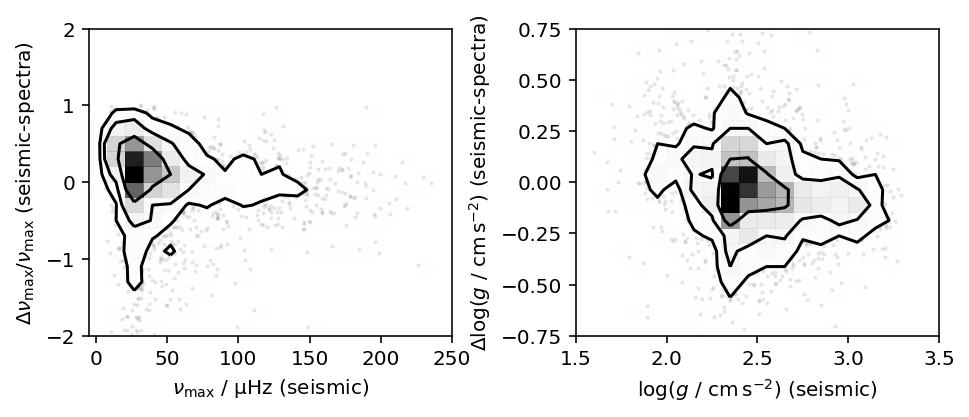

In [6]:
f, gs = plt.subplots(1,2,figsize=(7,3))

ax = gs[0]
corner.hist2d(
    joined['numax_mean'],
    (joined['numax_mean'] - nu_max_model)/joined['numax_mean'],
    ax=ax,
    bins=20,
    range = [(-5,250),(-2,2)]
)
ax.set_xlabel(r'$\nu_\mathrm{max}~/~\mathrm{\mu}\mathrm{Hz}$ (seismic)')
ax.set_ylabel(r'$\Delta\nu_\mathrm{max}/\nu_\mathrm{max}$ (seismic-spectra)')

ax = gs[1]
corner.hist2d(
    logg_seis,
    (logg_seis - joined['logg']),
    ax=ax,
    bins=20,
    range = [(1.5,3.5),(-0.75,0.75)]
)
ax.set_xlabel(r'$\log (g~/~\mathrm{cm\,s^{-2}})$ (seismic)')
ax.set_ylabel(r'$\Delta\log (g~/~\mathrm{cm\,s^{-2}})$ (seismic-spectra)')
plt.tight_layout()